In [1]:
from kuramoto.nmf import *
from kuramoto.SDL_BCD import SDL_BCD

In [2]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 1600
X.shape (2500, 1600)


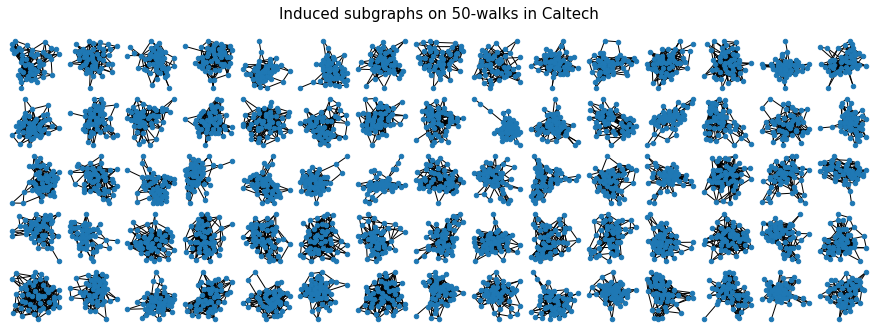

In [3]:
X, embs = G.get_patches(k=k, sample_size=1600, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 1600


In [65]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 0.35

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1596,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1597,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,False
1598,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


In [152]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.346875


In [129]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [138]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  3%|█▏                                         | 7/250 [00:00<00:08, 29.02it/s]

iteration 0, reconstruction error 267025.389563


  6%|██▋                                       | 16/250 [00:00<00:08, 26.81it/s]

iteration 10, reconstruction error 184307.806393


 10%|████▏                                     | 25/250 [00:00<00:06, 33.43it/s]

iteration 20, reconstruction error 181710.253361


 15%|██████▏                                   | 37/250 [00:01<00:07, 29.74it/s]

iteration 30, reconstruction error 173918.417746


 18%|███████▌                                  | 45/250 [00:01<00:06, 29.32it/s]

iteration 40, reconstruction error 169544.086918


 23%|█████████▌                                | 57/250 [00:01<00:05, 32.68it/s]

iteration 50, reconstruction error 168454.390453


 26%|███████████                               | 66/250 [00:02<00:05, 35.24it/s]

iteration 60, reconstruction error 168010.520108


 32%|█████████████▍                            | 80/250 [00:02<00:04, 38.48it/s]

iteration 70, reconstruction error 167769.304272


 34%|██████████████                            | 84/250 [00:02<00:04, 34.64it/s]

iteration 80, reconstruction error 167611.439406


 38%|████████████████▏                         | 96/250 [00:03<00:05, 29.40it/s]

iteration 90, reconstruction error 167498.175843


 42%|█████████████████▏                       | 105/250 [00:03<00:04, 34.54it/s]

iteration 100, reconstruction error 167410.494310


 46%|██████████████████▊                      | 115/250 [00:03<00:03, 36.35it/s]

iteration 110, reconstruction error 167339.816369


 51%|████████████████████▊                    | 127/250 [00:03<00:03, 34.22it/s]

iteration 120, reconstruction error 167280.809635


 54%|██████████████████████▏                  | 135/250 [00:04<00:03, 34.01it/s]

iteration 130, reconstruction error 167230.255767


 60%|████████████████████████▍                | 149/250 [00:04<00:02, 37.82it/s]

iteration 140, reconstruction error 167186.706558


 63%|█████████████████████████▋               | 157/250 [00:04<00:02, 36.77it/s]

iteration 150, reconstruction error 167148.984785


 66%|███████████████████████████              | 165/250 [00:05<00:02, 31.53it/s]

iteration 160, reconstruction error 167115.954620


 69%|████████████████████████████▎            | 173/250 [00:05<00:02, 30.95it/s]

iteration 170, reconstruction error 167086.623589


 74%|██████████████████████████████▎          | 185/250 [00:05<00:02, 29.96it/s]

iteration 180, reconstruction error 167060.614188


 79%|████████████████████████████████▍        | 198/250 [00:06<00:01, 34.68it/s]

iteration 190, reconstruction error 167037.090847


 82%|█████████████████████████████████▊       | 206/250 [00:06<00:01, 35.53it/s]

iteration 200, reconstruction error 167015.706575


 87%|███████████████████████████████████▊     | 218/250 [00:06<00:00, 33.40it/s]

iteration 210, reconstruction error 166996.067393


 91%|█████████████████████████████████████▏   | 227/250 [00:06<00:00, 36.34it/s]

iteration 220, reconstruction error 166978.031947


 94%|██████████████████████████████████████▋  | 236/250 [00:07<00:00, 35.48it/s]

iteration 230, reconstruction error 166961.415632


100%|████████████████████████████████████████▊| 249/250 [00:07<00:00, 36.08it/s]

iteration 240, reconstruction error 166946.065754


100%|█████████████████████████████████████████| 250/250 [00:07<00:00, 32.75it/s]




###########################
Shape of W_true: (2500, 9)
###########################




  1%|▎                                          | 2/250 [00:00<00:12, 19.30it/s]

iteration 0, reconstruction error 488407.585270


  6%|██▎                                       | 14/250 [00:00<00:09, 24.28it/s]

iteration 10, reconstruction error 337741.898009


 10%|████                                      | 24/250 [00:00<00:08, 25.93it/s]

iteration 20, reconstruction error 335176.065053


 13%|█████▌                                    | 33/250 [00:01<00:09, 23.77it/s]

iteration 30, reconstruction error 327137.885533


 18%|███████▌                                  | 45/250 [00:01<00:08, 24.12it/s]

iteration 40, reconstruction error 315895.676792


 22%|█████████                                 | 54/250 [00:02<00:08, 21.96it/s]

iteration 50, reconstruction error 312022.015223


 25%|██████████▌                               | 63/250 [00:02<00:08, 22.74it/s]

iteration 60, reconstruction error 310728.332218


 30%|████████████▌                             | 75/250 [00:03<00:08, 20.15it/s]

iteration 70, reconstruction error 310160.637980


 34%|██████████████                            | 84/250 [00:03<00:07, 22.88it/s]

iteration 80, reconstruction error 309841.433630


 38%|███████████████▉                          | 95/250 [00:04<00:05, 26.73it/s]

iteration 90, reconstruction error 309626.747075


 41%|████████████████▉                        | 103/250 [00:04<00:04, 29.80it/s]

iteration 100, reconstruction error 309467.348571


 46%|███████████████████                      | 116/250 [00:04<00:05, 26.38it/s]

iteration 110, reconstruction error 309341.625880


 50%|████████████████████▌                    | 125/250 [00:05<00:04, 25.45it/s]

iteration 120, reconstruction error 309238.401747


 54%|█████████████████████▉                   | 134/250 [00:05<00:04, 26.68it/s]

iteration 130, reconstruction error 309151.064727


 58%|███████████████████████▉                 | 146/250 [00:05<00:04, 25.91it/s]

iteration 140, reconstruction error 309075.113231


 62%|█████████████████████████▍               | 155/250 [00:06<00:03, 26.36it/s]

iteration 150, reconstruction error 309007.782294


 66%|███████████████████████████              | 165/250 [00:06<00:03, 27.35it/s]

iteration 160, reconstruction error 308947.283788


 70%|████████████████████████████▋            | 175/250 [00:07<00:02, 27.76it/s]

iteration 170, reconstruction error 308892.485746


 74%|██████████████████████████████▎          | 185/250 [00:07<00:02, 27.44it/s]

iteration 180, reconstruction error 308842.505109


 78%|███████████████████████████████▊         | 194/250 [00:07<00:02, 26.19it/s]

iteration 190, reconstruction error 308796.591327


 82%|█████████████████████████████████▍       | 204/250 [00:08<00:01, 26.00it/s]

iteration 200, reconstruction error 308754.089653


 86%|███████████████████████████████████▍     | 216/250 [00:08<00:01, 26.25it/s]

iteration 210, reconstruction error 308714.606129


 90%|████████████████████████████████████▉    | 225/250 [00:08<00:01, 24.86it/s]

iteration 220, reconstruction error 308677.891849


 94%|██████████████████████████████████████▌  | 235/250 [00:09<00:00, 27.47it/s]

iteration 230, reconstruction error 308643.837945


 98%|████████████████████████████████████████▏| 245/250 [00:09<00:00, 27.21it/s]

iteration 240, reconstruction error 308612.436106


100%|█████████████████████████████████████████| 250/250 [00:09<00:00, 25.36it/s]



###########################
Shape of W_false: (2500, 9)
###########################




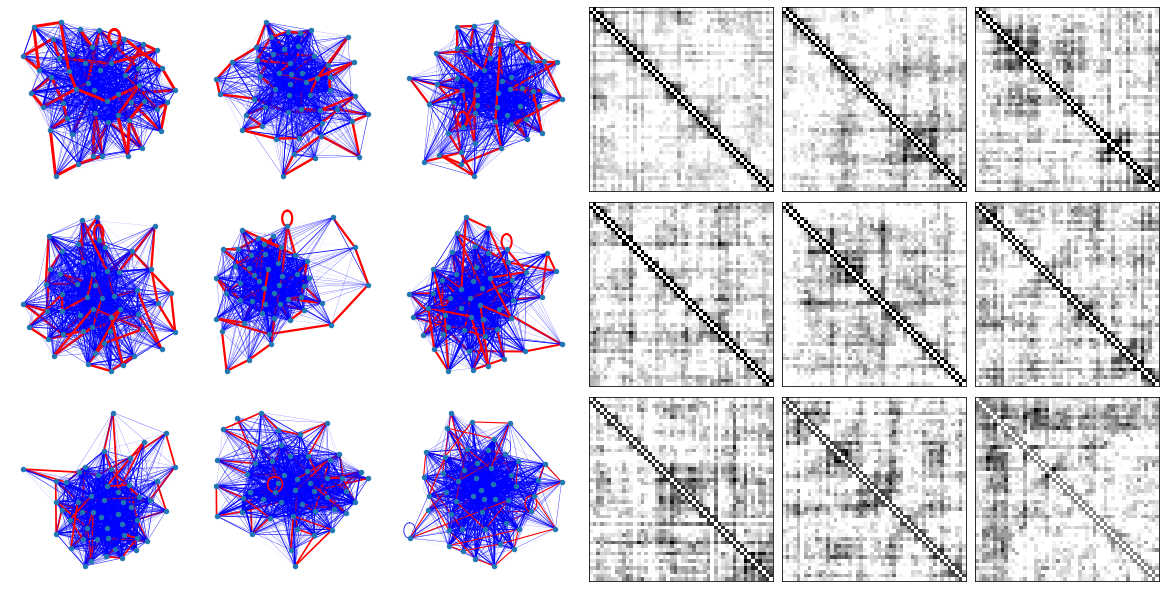

In [146]:
display_dict_and_graph(title=None,
                       save_path='report_figs/NMF_Caltech_True.png',
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

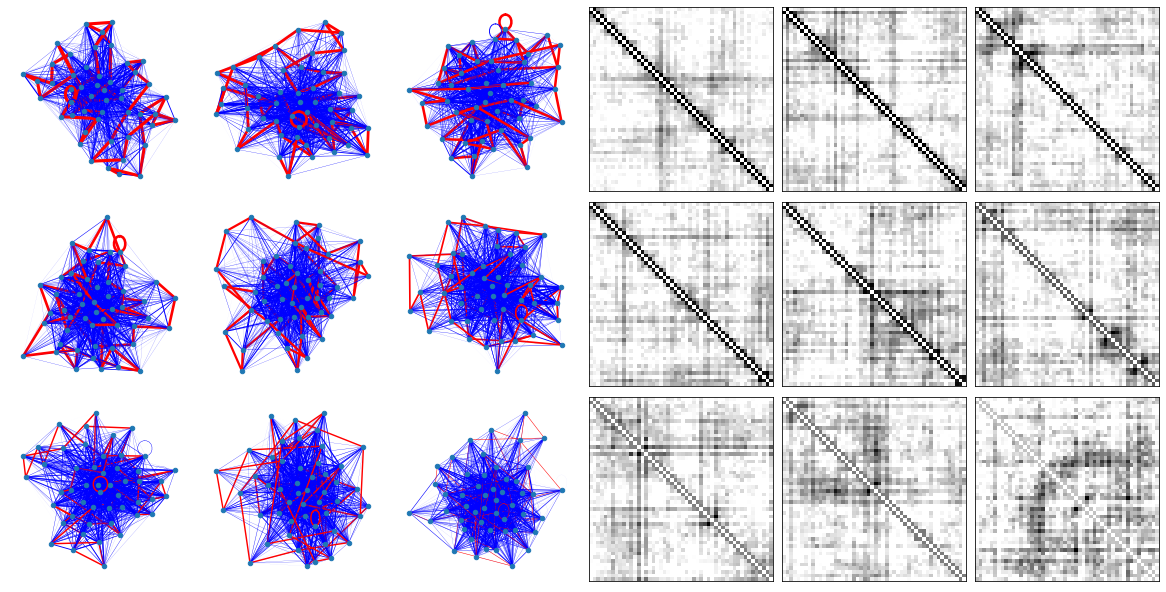

In [147]:
display_dict_and_graph(title=None,
                       save_path='report_figs/NMF_Caltech_False.png',
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

In [148]:
true_norm = np.linalg.norm(W_true.T, ord=1, axis=1)
false_norm = np.linalg.norm(W_false.T, ord=1, axis=1)

data_arr = np.stack((true_norm, false_norm), axis=0).T
df_boxplot = pd.DataFrame(data_arr, columns = ['Synchronizing','Non-Synchronizing'])
df_boxplot

,Synchronizing,Non-Synchronizing
0,10.042201,10.256532
1,10.831499,9.809583
2,10.503260,9.648190
3,10.296762,10.705163
4,10.250080,9.368304
5,10.094187,10.349258
6,10.720366,10.282067
7,10.575249,10.126333
8,10.301493,9.998088


In [149]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

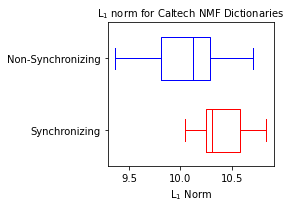

In [157]:
plt.figure(figsize=[4,3])
xlabs = ['Synchronizing', 'Non-Synchronizing']

bs = plt.boxplot(df_boxplot['Synchronizing'], sym='r+', widths=0.6, positions= [0], vert=False)
bns = plt.boxplot(df_boxplot['Non-Synchronizing'], sym='b+', widths=0.6, vert=False)
set_box_color(bs, 'r')
set_box_color(bns, 'b')
plt.yticks(range(len(xlabs)), xlabs, size='medium')
plt.xlabel('L$_1$ Norm', size='medium')
plt.title("L$_1$ norm for Caltech NMF Dictionaries", size="medium")
plt.tight_layout()
plt.savefig('report_figs/NMF_Caltech_Boxplot.png')

In [154]:
true_df_norm = np.linalg.norm(X_true.T, ord=1, axis=1)
false_df_norm = np.linalg.norm(X_false.T, ord=1, axis=1)

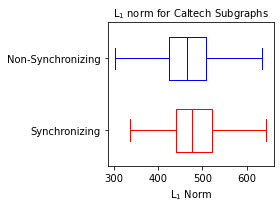

In [158]:
plt.figure(figsize=[4,3])
xlabs = ['Synchronizing', 'Non-Synchronizing']

bs_df = plt.boxplot(true_df_norm, sym='', widths=0.6, positions= [0], vert=False)
bns_df = plt.boxplot(false_df_norm, sym='', widths=0.6, vert=False)
set_box_color(bs_df, 'r')
set_box_color(bns_df, 'b')
plt.yticks(range(len(xlabs)), xlabs, size='medium')
plt.xlabel('L$_1$ Norm', size='medium')
plt.title("L$_1$ norm for Caltech Subgraphs", size="medium")
plt.tight_layout()
plt.savefig('report_figs/Subgraphs_Caltech_Boxplot.png')

In [153]:
df.to_pickle('datasets/caltech_50node_1600examples.pickle')

In [2]:
df = pd.read_pickle('datasets/caltech_50node_1600examples.pickle')

In [3]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

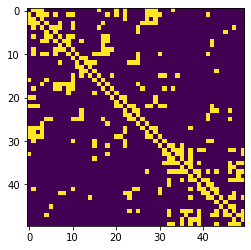

In [4]:
plt.imshow(X_true.T[50].reshape(50, 50))

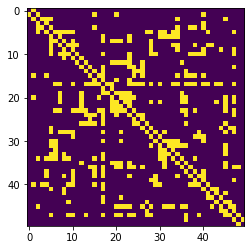

In [5]:
plt.imshow(X_false.T[50].reshape(50, 50))

In [6]:
sum(X_false.T[50])

436.0

In [7]:
sum(X_true.T[50])

376.0

In [85]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

rus = RandomUnderSampler(random_state=42)
X_res, Y_res = rus.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, 
                                                    test_size = 0.2,
                                                    stratify = Y_res)

Y_test = Y_test.T.reshape(-1,1)
Y_train = Y_train.T.reshape(-1,1)

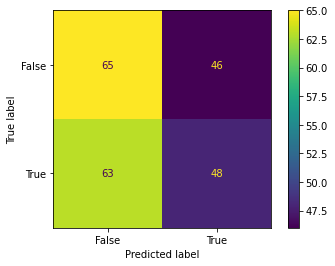

Precision: 0.511
Recall: 0.432
F1: 0.468
Accuracy: 0.509


In [86]:
clf = rf(max_depth=5, max_features="log2").fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
model_metrics(clf, Y_test, Y_pred)

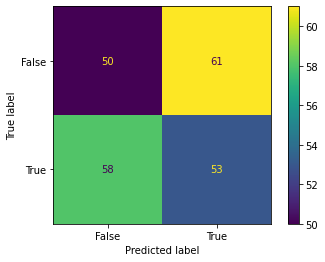

Precision: 0.465
Recall: 0.477
F1: 0.471
Accuracy: 0.464


In [87]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=0.1, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
model_metrics(clf, Y_test, Y_pred)

In [88]:
# SDL_BCD_feature
data_scale=10
results_dict_list = []
iteration1 = 50
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                X_test = [X_test.T/data_scale, Y_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new = SDL_BCD_class.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.93131046  0.92800597  0.92094319 -0.86997051 -0.59388418 -0.32198891
  -0.70054414  0.26927966 -0.63565885 -0.63388839]]


  2%|▉                                           | 1/50 [00:00<00:05,  9.70it/s]

--- Training --- [threshold, AUC] =  [0.578, 0.595]
--- Iteration 0: Training loss --- [Data, Label, Total] = [285.522753.3, 626.501456.3, 626.501456.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 41.07it/s]

--- Training --- [threshold, AUC] =  [0.998, 0.764]
--- Iteration 10: Training loss --- [Data, Label, Total] = [420.916681.3, 2731.994031.3, 2731.994031.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[-0.40262589 -0.19439948 -0.89590793 -0.30679036 -0.30209188  0.6367952
   0.0468547   0.50377128 -0.42291626 -0.21274016]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.495, 0.596]
--- Iteration 0: Training loss --- [Data, Label, Total] = [310.100171.3, 615.543189.3, 615.543189.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 50.49it/s]

--- Training --- [threshold, AUC] =  [0.972, 0.684]
--- Iteration 10: Training loss --- [Data, Label, Total] = [452.270874.3, 1599.175314.3, 1599.175314.3]
Early stopping: training loss increased


!!! pred_type naive
initial loading beta [[-0.43313748 -0.97270024  0.24785061 -0.37794311  0.21335083 -0.87416076
  -0.06102148  0.35746301 -0.30892902  0.04357519]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.501, 0.404]
--- Iteration 0: Training loss --- [Data, Label, Total] = [291.618838.3, 615.526085.3, 644.687969.3]


 36%|███████████████▍                           | 18/50 [00:00<00:00, 45.89it/s]

--- Training --- [threshold, AUC] =  [0.596, 0.537]
--- Iteration 10: Training loss --- [Data, Label, Total] = [418.031791.3, 631.988521.3, 673.791700.3]


 62%|██████████████████████████▋                | 31/50 [00:00<00:00, 48.34it/s]

--- Training --- [threshold, AUC] =  [0.555, 0.604]
--- Iteration 20: Training loss --- [Data, Label, Total] = [393.816645.3, 620.849746.3, 660.231411.3]
--- Training --- [threshold, AUC] =  [0.533, 0.641]
--- Iteration 30: Training loss --- [Data, Label, Total] = [369.545155.3, 617.318932.3, 654.273447.3]


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 48.18it/s]

--- Training --- [threshold, AUC] =  [0.528, 0.667]
--- Iteration 40: Training loss --- [Data, Label, Total] = [347.967573.3, 616.789987.3, 651.586745.3]
!!! pred_type naive


initial loading beta [[-0.87471859 -0.69886211  0.21660073 -0.88759646  0.13987556  0.08506178
   0.31881173  0.08899466  0.70532792 -0.19393446]]


  8%|███▌                                        | 4/50 [00:00<00:01, 37.33it/s]

--- Training --- [threshold, AUC] =  [0.558, 0.594]
--- Iteration 0: Training loss --- [Data, Label, Total] = [283.618675.3, 621.615411.3, 649.977278.3]


 20%|████████▌                                  | 10/50 [00:00<00:01, 37.03it/s]


--- Training --- [threshold, AUC] =  [0.983, 0.651]
--- Iteration 10: Training loss --- [Data, Label, Total] = [413.465545.3, 1818.439136.3, 1859.785691.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.06862512 -0.4282958  -0.40861604  0.8289979  -0.48712934  0.83517479
  -0.7546046  -0.25632374 -0.24485663 -0.92049489]]


 12%|█████▎                                      | 6/50 [00:00<00:00, 56.18it/s]

--- Training --- [threshold, AUC] =  [0.449, 0.598]
--- Iteration 0: Training loss --- [Data, Label, Total] = [269.039864.3, 620.127707.3, 889.167572.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 50.62it/s]


--- Training --- [threshold, AUC] =  [0.285, 0.628]
--- Iteration 10: Training loss --- [Data, Label, Total] = [281.882008.3, 705.896081.3, 987.778089.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.78343653  0.22032249  0.39223085  0.69281354 -0.22877821 -0.80900566
   0.24172663 -0.33260416  0.43887336  0.02923098]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.593, 0.406]
--- Iteration 0: Training loss --- [Data, Label, Total] = [273.691456.3, 631.195037.3, 904.886494.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 47.45it/s]

--- Training --- [threshold, AUC] =  [0.999, 0.425]
--- Iteration 10: Training loss --- [Data, Label, Total] = [265.983817.3, 2922.707185.3, 3188.691002.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[ 0.17160489 -0.48638755  0.65177329 -0.40852521 -0.86505736  0.65874344
   0.61888603  0.30826494 -0.2448536   0.9854861 ]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.594, 0.596]
--- Iteration 0: Training loss --- [Data, Label, Total] = [237.592231.3, 631.496478.3, 1819.457634.3]


 20%|████████▌                                  | 10/50 [00:00<00:01, 32.16it/s]


--- Training --- [threshold, AUC] =  [0.987, 0.45]
--- Iteration 10: Training loss --- [Data, Label, Total] = [129.618607.3, 1952.536659.3, 2600.629692.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.15989836 -0.02240255  0.01425548  0.1428667  -0.2522684   0.24206001
   0.80916189 -0.10790122  0.12483506  0.56473075]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.522, 0.598]
--- Iteration 0: Training loss --- [Data, Label, Total] = [232.588871.3, 616.356320.3, 1779.300676.3]


 24%|██████████▎                                | 12/50 [00:00<00:00, 56.01it/s]

--- Training --- [threshold, AUC] =  [0.683, 0.493]
--- Iteration 10: Training loss --- [Data, Label, Total] = [123.512280.3, 679.377107.3, 1296.938509.3]


 42%|██████████████████                         | 21/50 [00:00<00:00, 59.98it/s]

--- Training --- [threshold, AUC] =  [0.6, 0.494]
--- Iteration 20: Training loss --- [Data, Label, Total] = [76.240820.3, 633.714337.3, 1014.918434.3]


 58%|████████████████████████▉                  | 29/50 [00:00<00:00, 66.48it/s]

--- Training --- [threshold, AUC] =  [0.453, 0.546]
--- Iteration 30: Training loss --- [Data, Label, Total] = [57.591569.3, 619.442543.3, 907.400388.3]


 86%|████████████████████████████████████▉      | 43/50 [00:00<00:00, 65.08it/s]

--- Training --- [threshold, AUC] =  [0.394, 0.7]
--- Iteration 40: Training loss --- [Data, Label, Total] = [3.589407.3, 636.066329.3, 654.013365.3]


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 65.10it/s]

!!! pred_type naive


initial loading beta [[-0.1276488   0.51557478  0.76447585  0.35361878  0.87899282 -0.86288695
  -0.7208796  -0.77239047  0.167267   -0.09265961]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.6, 0.404]
--- Iteration 0: Training loss --- [Data, Label, Total] = [248.454541.3, 633.476427.3, 3118.021840.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 49.59it/s]

--- Training --- [threshold, AUC] =  [1.0, 0.641]
--- Iteration 10: Training loss --- [Data, Label, Total] = [118.516667.3, 3722.539417.3, 4907.706083.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[-0.98398083 -0.56550362  0.43773929 -0.33229843 -0.07529362  0.76968057
   0.39856249  0.50117175  0.14796546 -0.98124987]]


 12%|█████▎                                      | 6/50 [00:00<00:00, 59.73it/s]

--- Training --- [threshold, AUC] =  [0.479, 0.592]
--- Iteration 0: Training loss --- [Data, Label, Total] = [243.051617.3, 616.313420.3, 3046.829587.3]
--- Training --- [threshold, AUC] =  [0.537, 0.467]
--- Iteration 10: Training loss --- [Data, Label, Total] = [128.391905.3, 618.124027.3, 1902.043079.3]


 64%|███████████████████████████▌               | 32/50 [00:00<00:00, 57.60it/s]

--- Training --- [threshold, AUC] =  [0.053, 0.591]
--- Iteration 20: Training loss --- [Data, Label, Total] = [70.173540.3, 1328.834223.3, 2030.569625.3]
--- Training --- [threshold, AUC] =  [0.028, 0.765]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.632578.3, 1592.657412.3, 1608.983196.3]


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 64.46it/s]

--- Training --- [threshold, AUC] =  [0.029, 0.776]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.157515.3, 1591.704607.3, 1603.279761.3]
!!! pred_type naive


In [89]:
W = results_dict_new['loading'][0]
coeff = results_dict_new['loading'][1][0]
H = results_dict_new['code']

In [90]:
coeff

array([-0.00224662,  0.09467644,  0.00349922,  0.00208159,  0.00185113,
        0.00207759,  0.00173279,  0.00175719,  0.00164616,  0.00273076])

In [91]:
print('Accuracy: {}'.format(results_dict_new['Accuracy']))

Accuracy: 0.5045045045045045


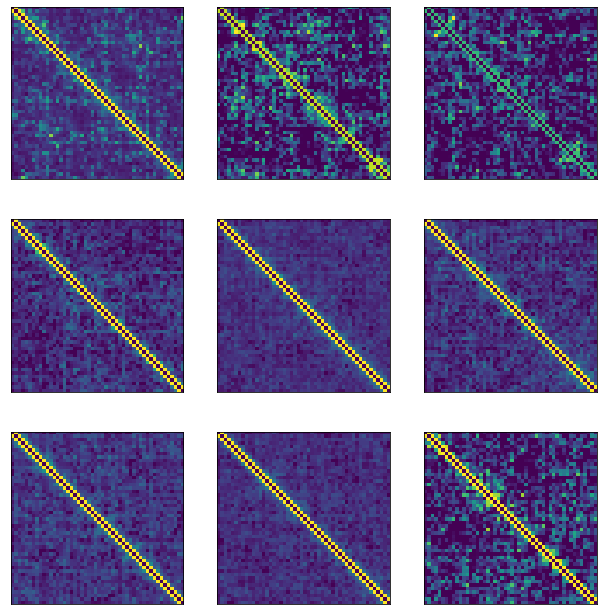

In [92]:
display_dictionary(W = W, figsize=[10,10])

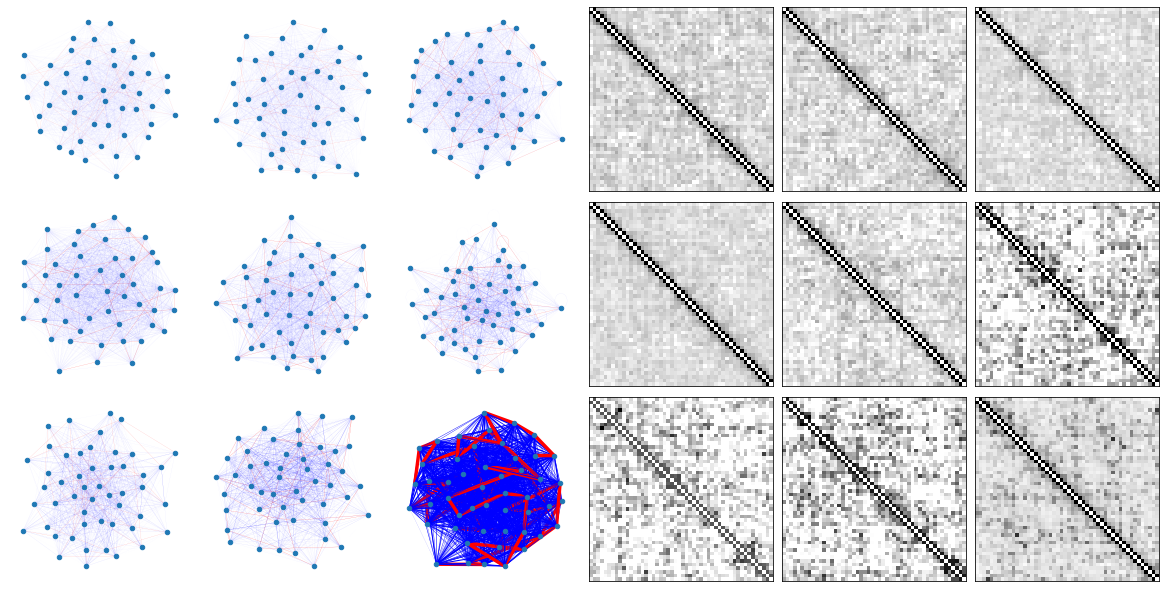

In [93]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T),
                       weight_graph = 50, 
                       fig_size = [20,10], 
                       show_importance = True)

In [94]:
# SDL_BCD_filter
data_scale=1
results_dict_list_filter = []
iteration1 = 50
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class_filter = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                       X_test = [X_test.T/data_scale, Y_test.T],
                                       n_components = r,
                                       xi = xi,
                                       L1_reg = [0,0,0],
                                       L2_reg = [0,0,0],
                                       nonnegativity = [True,True,False],
                                       full_dim = False)

        results_dict_new_filter = SDL_BCD_class_filter.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.86832209  0.21911778 -0.67878925  0.45750469 -0.53817548 -0.69487469
   0.31653262 -0.62215889 -0.47304918 -0.35430826]]


  2%|▉                                           | 1/50 [00:00<00:06,  7.04it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [156.344303.3, 615.490450.3, 615.490450.3]


 26%|███████████▏                               | 13/50 [00:01<00:03, 12.26it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.616]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.505618.3, 615.476152.3, 615.476152.3]


 46%|███████████████████▊                       | 23/50 [00:01<00:02, 12.23it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.729]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.471547.3, 615.355428.3, 615.355428.3]


 66%|████████████████████████████▍              | 33/50 [00:02<00:01, 11.66it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.788]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.554789.3, 615.284019.3, 615.284019.3]


 82%|███████████████████████████████████▎       | 41/50 [00:03<00:00, 12.56it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.796]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.576370.3, 615.279678.3, 615.279678.3]


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 12.07it/s]


!!! pred_type filter
initial loading beta [[-0.12718015  0.96785967 -0.63946801 -0.21286344 -0.39555034  0.96002821
   0.30337422 -0.51272737  0.08255096  0.69173725]]


  2%|▉                                           | 1/50 [00:00<00:04,  9.99it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.592]
--- Iteration 0: Training loss --- [Data, Label, Total] = [159.542349.3, 615.490429.3, 615.490429.3]


 26%|███████████▏                               | 13/50 [00:01<00:02, 12.91it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.616]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.504156.3, 615.475731.3, 615.475731.3]


 46%|███████████████████▊                       | 23/50 [00:01<00:01, 13.68it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.731]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.475333.3, 615.353210.3, 615.353210.3]


 66%|████████████████████████████▍              | 33/50 [00:02<00:01, 14.27it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.788]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.555765.3, 615.283870.3, 615.283870.3]


 86%|████████████████████████████████████▉      | 43/50 [00:03<00:00, 12.89it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.796]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.576582.3, 615.279671.3, 615.279671.3]


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 12.30it/s]


!!! pred_type filter
initial loading beta [[ 0.20719666  0.69216996 -0.16641545 -0.04906701 -0.11957596 -0.46830488
  -0.94495359 -0.93669178 -0.43717151  0.77027917]]


  4%|█▊                                          | 2/50 [00:00<00:07,  6.38it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.59]
--- Iteration 0: Training loss --- [Data, Label, Total] = [163.306540.3, 615.492507.3, 631.823161.3]


 24%|██████████▎                                | 12/50 [00:01<00:03, 11.20it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.607]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.475119.3, 615.484247.3, 615.631759.3]


 44%|██████████████████▉                        | 22/50 [00:02<00:02,  9.95it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.679]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.262388.3, 615.424442.3, 615.550681.3]


 64%|███████████████████████████▌               | 32/50 [00:03<00:02,  8.54it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.747]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.199239.3, 615.342256.3, 615.462180.3]


 86%|████████████████████████████████████▉      | 43/50 [00:04<00:00,  9.97it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.774]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.145392.3, 615.308454.3, 615.422993.3]


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.29it/s]


!!! pred_type filter
initial loading beta [[-0.94770347  0.23545938 -0.75277692 -0.94231696  0.91589384 -0.20114721
   0.06352084  0.61218089 -0.92124544 -0.53413901]]


  6%|██▋                                         | 3/50 [00:00<00:04, 10.47it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.593]
--- Iteration 0: Training loss --- [Data, Label, Total] = [161.314877.3, 615.491965.3, 631.623453.3]


 26%|███████████▏                               | 13/50 [00:01<00:02, 12.38it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.61]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.497313.3, 615.483979.3, 615.633711.3]


 46%|███████████████████▊                       | 23/50 [00:01<00:01, 14.03it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.677]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.263318.3, 615.428616.3, 615.554948.3]


 66%|████████████████████████████▍              | 33/50 [00:02<00:01, 14.46it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.745]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.208074.3, 615.346623.3, 615.467431.3]


 86%|████████████████████████████████████▉      | 43/50 [00:03<00:00, 12.46it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.773]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.165010.3, 615.309892.3, 615.426393.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.08it/s]


!!! pred_type filter
initial loading beta [[-0.68890357  0.47023083 -0.37483175  0.29382173  0.48668234 -0.35233277
  -0.76317315 -0.07091039 -0.88823216 -0.32503486]]


  6%|██▋                                         | 3/50 [00:00<00:04, 11.23it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.595]
--- Iteration 0: Training loss --- [Data, Label, Total] = [212.538480.3, 615.498515.3, 828.036995.3]


 26%|███████████▏                               | 13/50 [00:00<00:02, 14.89it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.595]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.328444.3, 615.503474.3, 616.831917.3]


 46%|███████████████████▊                       | 23/50 [00:01<00:01, 14.57it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.6]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.134755.3, 615.501886.3, 616.636641.3]


 66%|████████████████████████████▍              | 33/50 [00:02<00:01, 14.01it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.605]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.112171.3, 615.500303.3, 616.612474.3]


 86%|████████████████████████████████████▉      | 43/50 [00:03<00:00, 11.84it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.61]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.103834.3, 615.498560.3, 616.602394.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.33it/s]


!!! pred_type filter
initial loading beta [[ 0.61565083 -0.5213801   0.38448984  0.84583728 -0.4311684  -0.90145106
   0.96625154  0.73881341 -0.72531115  0.60835739]]


  2%|▉                                           | 1/50 [00:00<00:04,  9.84it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.592]
--- Iteration 0: Training loss --- [Data, Label, Total] = [210.995796.3, 615.499721.3, 826.495517.3]


 26%|███████████▏                               | 13/50 [00:00<00:02, 14.84it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.595]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.346501.3, 615.503921.3, 616.850422.3]


 46%|███████████████████▊                       | 23/50 [00:01<00:02, 13.19it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.601]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.128616.3, 615.501904.3, 616.630521.3]


 66%|████████████████████████████▍              | 33/50 [00:02<00:01, 12.28it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.607]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.105124.3, 615.499849.3, 616.604973.3]


 86%|████████████████████████████████████▉      | 43/50 [00:03<00:00, 14.25it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.614]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.097531.3, 615.497531.3, 616.595062.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.49it/s]


!!! pred_type filter
initial loading beta [[ 0.16809796  0.73084307  0.20093198  0.33102891  0.4246804  -0.8302669
  -0.16561937  0.33127623 -0.88095914  0.9808087 ]]


  2%|▉                                           | 1/50 [00:00<00:05,  8.40it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.591]
--- Iteration 0: Training loss --- [Data, Label, Total] = [206.338748.3, 615.510768.3, 1647.204510.3]


 26%|███████████▏                               | 13/50 [00:00<00:02, 13.68it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.571]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.462975.3, 615.512005.3, 622.826880.3]


 46%|███████████████████▊                       | 23/50 [00:01<00:02, 13.19it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.571]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.138695.3, 615.511947.3, 621.205420.3]


 66%|████████████████████████████▍              | 33/50 [00:02<00:01, 12.51it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.571]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.116017.3, 615.511874.3, 621.091960.3]


 86%|████████████████████████████████████▉      | 43/50 [00:03<00:00, 12.56it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.572]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.107308.3, 615.511801.3, 621.048344.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.20it/s]


!!! pred_type filter
initial loading beta [[ 0.73759305  0.90313803 -0.50421338 -0.09588295  0.26625181  0.07175453
   0.51043211 -0.80319027  0.37098208 -0.49218731]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.594]
--- Iteration 0: Training loss --- [Data, Label, Total] = [205.656686.3, 615.510391.3, 1643.793818.3]


 28%|████████████                               | 14/50 [00:01<00:02, 14.19it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.585]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.464564.3, 615.511653.3, 622.834472.3]


 48%|████████████████████▋                      | 24/50 [00:01<00:01, 14.81it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.584]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.148282.3, 615.511581.3, 621.252992.3]


 68%|█████████████████████████████▏             | 34/50 [00:02<00:01, 14.95it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.585]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.121541.3, 615.511504.3, 621.119210.3]


 84%|████████████████████████████████████       | 42/50 [00:02<00:00, 14.42it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.585]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.114984.3, 615.511428.3, 621.086350.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 14.60it/s]


!!! pred_type filter
initial loading beta [[-0.27242563  0.40963067  0.41625158  0.24048707 -0.55835379  0.47201025
  -0.18006005  0.20817888 -0.38295364 -0.91104046]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.567]
--- Iteration 0: Training loss --- [Data, Label, Total] = [158.131156.3, 615.514446.3, 2196.826007.3]


 24%|██████████▎                                | 12/50 [00:00<00:02, 14.10it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.535]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.671897.3, 615.514497.3, 632.233466.3]


 44%|██████████████████▉                        | 22/50 [00:01<00:02, 13.57it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.535]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.672537.3, 615.514496.3, 632.239864.3]


 64%|███████████████████████████▌               | 32/50 [00:02<00:01, 13.91it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.535]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.671684.3, 615.514495.3, 632.231332.3]


 88%|█████████████████████████████████████▊     | 44/50 [00:03<00:00, 14.48it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.535]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.670696.3, 615.514494.3, 632.221458.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 14.28it/s]


!!! pred_type filter
initial loading beta [[ 0.97029413 -0.24335687  0.97847845 -0.36202666  0.44391339 -0.97747506
  -0.92584448  0.5827893   0.00117682  0.20325859]]


  2%|▉                                           | 1/50 [00:00<00:05,  8.89it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.548]
--- Iteration 0: Training loss --- [Data, Label, Total] = [178.739531.3, 615.514601.3, 2402.909910.3]


 26%|███████████▏                               | 13/50 [00:00<00:02, 14.84it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.529]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.655490.3, 615.514695.3, 632.069592.3]


 46%|███████████████████▊                       | 23/50 [00:01<00:01, 15.37it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.529]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.655771.3, 615.514695.3, 632.072407.3]


 66%|████████████████████████████▍              | 33/50 [00:02<00:01, 15.47it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.529]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.651125.3, 615.514695.3, 632.025949.3]


 86%|████████████████████████████████████▉      | 43/50 [00:02<00:00, 15.49it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.53]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.644472.3, 615.514695.3, 631.959418.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 15.30it/s]


!!! pred_type filter


In [95]:
W = results_dict_new_filter['loading'][0]
coeff = results_dict_new_filter['loading'][1][0]
H = results_dict_new_filter['code']

In [96]:
coeff

array([-1.04712683e-05,  1.34861132e-03,  1.36230198e-03,  2.67199499e-03,
        2.32496359e-03,  2.38667206e-03,  1.86130801e-03,  2.51193934e-03,
        1.26735237e-03,  1.79454190e-03])

In [97]:
print('Accuracy: {}'.format(results_dict_new_filter['Accuracy']))

Accuracy: 0.536036036036036


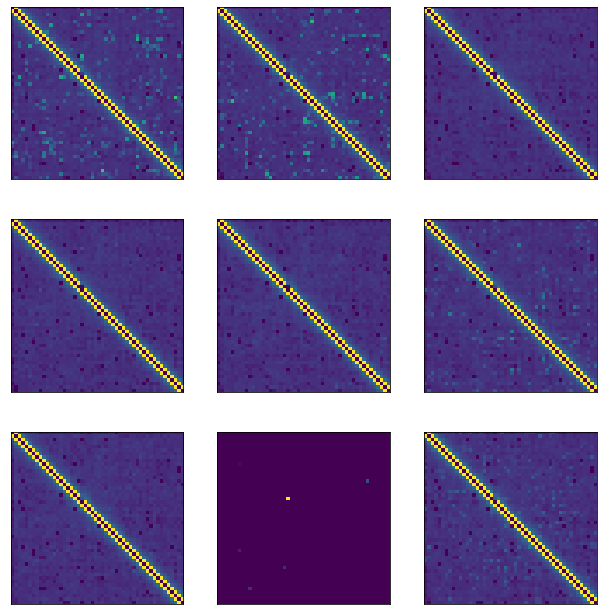

In [98]:
display_dictionary(W = W, figsize=[10,10])

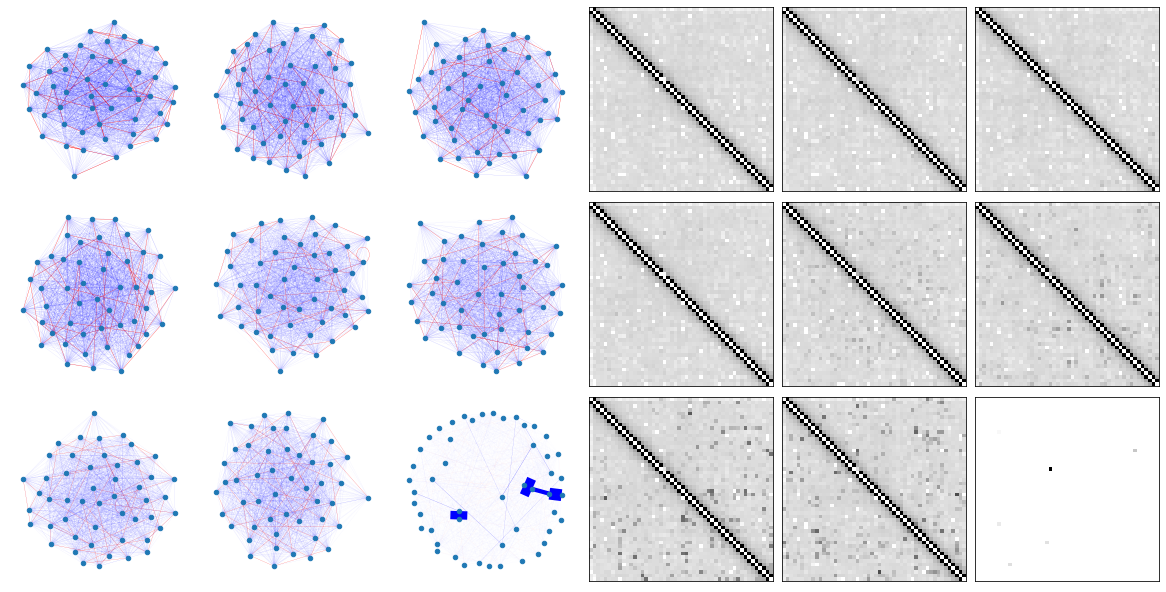

In [99]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       weight_graph = 150, 
                       fig_size = [20,10], 
                       show_importance = True)